# Reults analysis to plot figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import re

In [2]:
from glob import glob

In [3]:
def load_results(model_name: str, new_name: str, axis_name: str = None) -> pd.DataFrame:
    path = '/data/stympopper/didacticWORKSHOP/' + model_name + '/seed[0-9][0-9]/predictions/test_categorical_scores.csv'
    files = glob(path)
    if not files:
        raise ValueError("No files found")
    results = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0) 
        df = df.loc[["acc", "auroc", "auroc_wht", "auroc_controlled", "auroc_uncontrolled"]]["ht_severity_prediction"].reset_index().rename(columns={"index": "Metric"})
        results = pd.concat([results, df], axis=0)
    results = results.reset_index(drop=True)
    results["ht_severity_prediction"] = pd.to_numeric(results["ht_severity_prediction"], downcast="float")
    results["model_name"] = new_name
    results["axis_name"] = axis_name
    return results[results["Metric"]=="auroc"]

In [4]:
# Plot box plot for results
def plot_results(results: pd.DataFrame, model_name: str, hue: str = None, diplay_mean_value: bool = True):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(
        x="axis_name",
        y="ht_severity_prediction",
        data=results,
        palette="Set3",
        hue=hue,
        # hue_order=results[hue].unique(),
        showfliers=False,
        showmeans=False,
        # width=4,
        gap=0.1
    )
    if diplay_mean_value:
        # Get the mean values
        means = results.groupby('model_name')['ht_severity_prediction'].mean()
        means = means.reindex(results["model_name"].unique())

        vertical_offset = results['ht_severity_prediction'].mean() * - 0.001 # offset from mean for display
        horizontal_offset = + 0.0 # offset from mean for display
        
        for i, xtick in enumerate(ax.get_xticks()):
            ax.text(xtick+horizontal_offset,means[i] + vertical_offset,f'Mean:{means[i]:.3f}', 
                    horizontalalignment='center',size='large',color='teal',weight='bold')

    # # Annotate the mean values
    # for i, mean in enumerate(means):
    #     ax.annotate(f'{mean:.2f}', xy=(positions[i], mean), xytext=(0, 10), 
    #                 textcoords='offset points', ha='center', va='bottom')
    ax.set_title(model_name, fontsize=20)
    ax.set_ylabel("AUROC")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    # Move the legend to the bottom-left
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels)
    sns.move_legend(ax, "lower left")
    plt.legend(fontsize='large')
    plt.tight_layout()
    plt.show()

## SOTA and losses

In [189]:
df_results = load_results("TEST-CONSISTENCY", "MuFDI", "A")
df_results = pd.concat([df_results, load_results("TEST-bidirectional", "Bi-directional encoder (IRENE)", "B")])
df_results = pd.concat([df_results, load_results("TEST-FT-Transformer-2UniFTs", "FT-Transformer Encoder", "C")])
df_results = pd.concat([df_results, load_results("TEST-LXMERT-new", "LXMERT encoder", "D")]).reset_index().drop(columns=["index"])


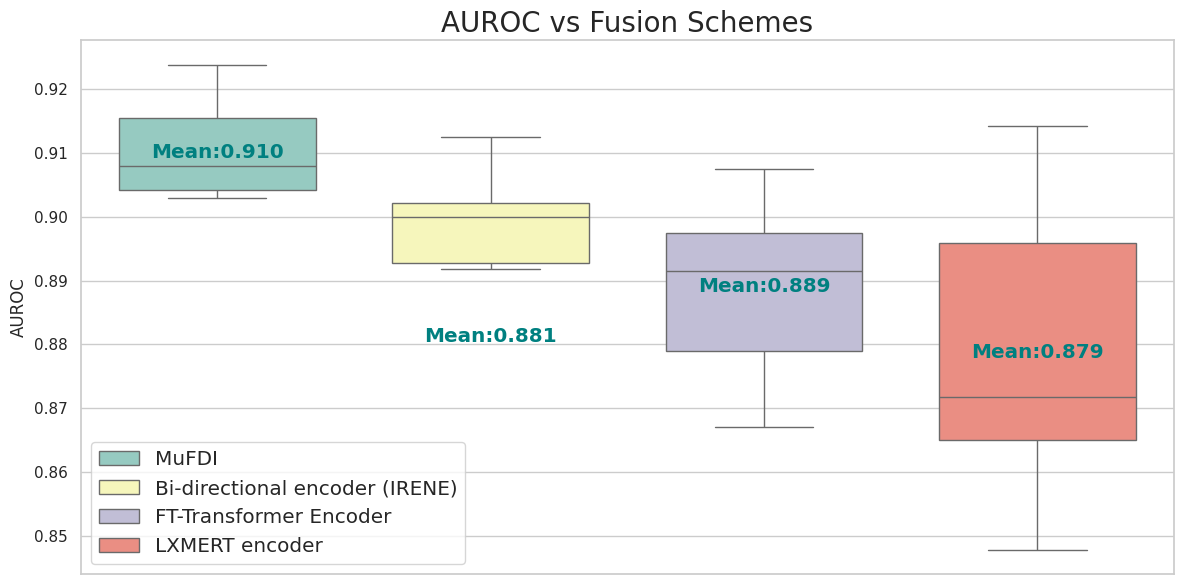

In [190]:
plot_results(df_results, "AUROC vs Fusion Schemes", hue="model_name")

In [186]:
df_2_results = load_results("TEST-CONSISTENCY", "InfoNCE/SupConCLIP", "A")
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-SupInfo-CLIP-invert-margin7-3", "SupInfo/CLIP (0.7-0.3)", "B")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-SupInfo-CLIP-invert-margin10-4", "SupInfo/CLIP (1.0-0.4)", "C")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-SupInfo2-CLIP-invert-margin50-30", "SupInfo/CLIP (5.0-3.0)", "H")])
df_2_results = pd.concat([df_2_results,load_results("TEST-FT-2UniFTs-Interleaved", "No decoupling module", "AB")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-NTXonly", "InfoNCE only", "E")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-SupCLIPonly", "SupConCLIP only", "F")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleavec-NTX-CLIP", "InfoNCE/CLIP", "D")])
df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-TripletSoftPlus-CLIP", "Triplet/CLIP", "G")])
# df_2_results = pd.concat([df_2_results,load_results("TEST-Decoupling-FT-2UniFTs-interleaved-SupInfo-CLIP-invert-margin100-300", "SupInfo10-30/CLIP")])

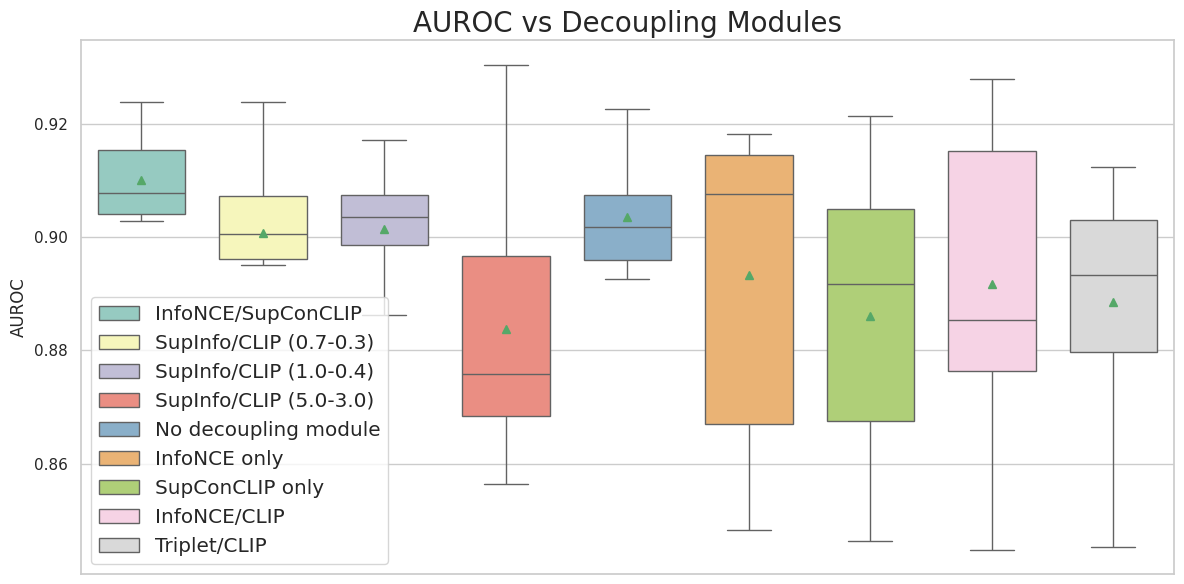

In [187]:
plot_results(df_2_results, "AUROC vs Decoupling Modules", hue="model_name", diplay_mean_value=False)

## Hyperparameters sensitivity